In [139]:
import os
import re
import requests
import pandas as pd
import xml.sax
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
from IPython import display
import numpy as np

In [140]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Downloading Wikipedia Dumps

In [8]:
project = 'enwiki'
dump_date = "20220420"
dataset_home = '/home/cse/phd/anz198717/scratch/suchith_data/wikipedia/wikipedia-data-science'

### fetch data from the scraping the webpage

#### wikipedia dumps

In [20]:
base_url = f'https://dumps.wikimedia.org/{project}/'
base_url

'https://dumps.wikimedia.org/enwiki/'

In [5]:
index = requests.get(base_url).text
index

'<html>\r\n<head><title>Index of /enwiki/</title></head>\r\n<body bgcolor="white">\r\n<h1>Index of /enwiki/</h1><hr><pre><a href="../">../</a>\r\n<a href="20220201/">20220201/</a>                                          21-Mar-2022 01:28                   -\r\n<a href="20220220/">20220220/</a>                                          02-Apr-2022 01:27                   -\r\n<a href="20220301/">20220301/</a>                                          02-May-2022 01:25                   -\r\n<a href="20220320/">20220320/</a>                                          02-May-2022 01:27                   -\r\n<a href="20220401/">20220401/</a>                                          07-Apr-2022 21:43                   -\r\n<a href="20220420/">20220420/</a>                                          22-Apr-2022 07:09                   -\r\n<a href="20220501/">20220501/</a>                                          07-May-2022 23:00                   -\r\n<a href="latest/">latest/</a>             

In [21]:
soup_index = BeautifulSoup(index, 'html.parser')
dumps = [ a.text for a in soup_index.find_all('a') if a.has_attr('href')]
dumps

['../',
 '20220201/',
 '20220220/',
 '20220301/',
 '20220320/',
 '20220401/',
 '20220420/',
 '20220501/',
 'latest/']

In [9]:
dump_url = base_url + dump_date
dump_html = requests.get(dump_url).text

soup_dump = BeautifulSoup(dump_html, 'html.parser')

In [10]:
soup_dump.find_all('li', {'class': 'file'}, limit=10)[:4]

[<li class="file"><a href="/enwiki/20220420/enwiki-20220420-pages-articles-multistream.xml.bz2">enwiki-20220420-pages-articles-multistream.xml.bz2</a> 19.3 GB</li>,
 <li class="file"><a href="/enwiki/20220420/enwiki-20220420-pages-articles-multistream-index.txt.bz2">enwiki-20220420-pages-articles-multistream-index.txt.bz2</a> 230.0 MB</li>,
 <li class="file"><a href="/enwiki/20220420/enwiki-20220420-pages-articles-multistream1.xml-p1p41242.bz2">enwiki-20220420-pages-articles-multistream1.xml-p1p41242.bz2</a> 247.4 MB</li>,
 <li class="file"><a href="/enwiki/20220420/enwiki-20220420-pages-articles-multistream-index1.txt-p1p41242.bz2">enwiki-20220420-pages-articles-multistream-index1.txt-p1p41242.bz2</a> 221 KB</li>]

In [11]:
files = []

for file in soup_dump.find_all('li', {'class': 'file'}):
    text = file.text
    files.append((text.split(' ')[0], text.split(' ')[1:]))

In [12]:
files[:4]

[('enwiki-20220420-pages-articles-multistream.xml.bz2', ['19.3', 'GB']),
 ('enwiki-20220420-pages-articles-multistream-index.txt.bz2', ['230.0', 'MB']),
 ('enwiki-20220420-pages-articles-multistream1.xml-p1p41242.bz2',
  ['247.4', 'MB']),
 ('enwiki-20220420-pages-articles-multistream-index1.txt-p1p41242.bz2',
  ['221', 'KB'])]

In [13]:
file_to_download = [ file[0] for file in files 
                    if '.xml-p' in file[0] and 'pages-articles' in file[0] and 'multistream' in file[0]]

In [14]:
file_to_download[-5:]

['enwiki-20220420-pages-articles-multistream27.xml-p63975910p65475909.bz2',
 'enwiki-20220420-pages-articles-multistream27.xml-p65475910p66975909.bz2',
 'enwiki-20220420-pages-articles-multistream27.xml-p66975910p68475909.bz2',
 'enwiki-20220420-pages-articles-multistream27.xml-p68475910p69975909.bz2',
 'enwiki-20220420-pages-articles-multistream27.xml-p69975910p70585441.bz2']

In [15]:
import sys
import ssl
import tensorflow as tf

ssl._create_default_https_context = ssl._create_unverified_context

2022-05-08 19:45:19.698742: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-08 19:45:19.699107: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [16]:
data_paths = []
file_info = []


for file in file_to_download:
    path = f'{dataset_home}/datasets/{file}'
    
    if not os.path.exists(path):
        data_paths.append( tf.keras.utils.get_file(origin=f'{dump_url}/{file}', cache_dir=dataset_home) )
    else:
        data_paths.append(path)
        
    file_size = os.stat(path).st_size/1e6
    file_articles = int(file.split('p')[-1].split('.')[0]) - int(file.split('p')[-2])
    file_info.append((file, file_size, file_articles))

#### Abstracts

In [24]:
base_url = f'https://dumps.wikimedia.org/{project}/'

index = requests.get(base_url).text

soup_index = BeautifulSoup(index, 'html.parser')
dumps = [ a.text for a in soup_index.find_all('a') if a.has_attr('href')]

dump_url = base_url + dump_date
dump_html = requests.get(dump_url).text
soup_dump = BeautifulSoup(dump_html, 'html.parser')

In [26]:
files = []

for file in soup_dump.find_all('li', {'class': 'file'}):
    text = file.text
    files.append((text.split(' ')[0], text.split(' ')[1:]))

In [27]:
files[:4]

[('enwiki-20220420-pages-articles-multistream.xml.bz2', ['19.3', 'GB']),
 ('enwiki-20220420-pages-articles-multistream-index.txt.bz2', ['230.0', 'MB']),
 ('enwiki-20220420-pages-articles-multistream1.xml-p1p41242.bz2',
  ['247.4', 'MB']),
 ('enwiki-20220420-pages-articles-multistream-index1.txt-p1p41242.bz2',
  ['221', 'KB'])]

In [30]:
files

[('enwiki-20220420-pages-articles-multistream.xml.bz2', ['19.3', 'GB']),
 ('enwiki-20220420-pages-articles-multistream-index.txt.bz2', ['230.0', 'MB']),
 ('enwiki-20220420-pages-articles-multistream1.xml-p1p41242.bz2',
  ['247.4', 'MB']),
 ('enwiki-20220420-pages-articles-multistream-index1.txt-p1p41242.bz2',
  ['221', 'KB']),
 ('enwiki-20220420-pages-articles-multistream2.xml-p41243p151573.bz2',
  ['331.8', 'MB']),
 ('enwiki-20220420-pages-articles-multistream-index2.txt-p41243p151573.bz2',
  ['639', 'KB']),
 ('enwiki-20220420-pages-articles-multistream3.xml-p151574p311329.bz2',
  ['360.0', 'MB']),
 ('enwiki-20220420-pages-articles-multistream-index3.txt-p151574p311329.bz2',
  ['820', 'KB']),
 ('enwiki-20220420-pages-articles-multistream4.xml-p311330p558391.bz2',
  ['401.0', 'MB']),
 ('enwiki-20220420-pages-articles-multistream-index4.txt-p311330p558391.bz2',
  ['1.3', 'MB']),
 ('enwiki-20220420-pages-articles-multistream5.xml-p558392p958045.bz2',
  ['431.2', 'MB']),
 ('enwiki-2022042

In [33]:
pattern = re.compile(f'{project}-{dump_date}-abstract'+r'[0-9]{1,2}.xml.gz')
file_to_download = [ file[0] for file in files if pattern.match(file[0])]

In [35]:
file_to_download[:10]

['enwiki-20220420-abstract1.xml.gz',
 'enwiki-20220420-abstract2.xml.gz',
 'enwiki-20220420-abstract3.xml.gz',
 'enwiki-20220420-abstract4.xml.gz',
 'enwiki-20220420-abstract5.xml.gz',
 'enwiki-20220420-abstract6.xml.gz',
 'enwiki-20220420-abstract7.xml.gz',
 'enwiki-20220420-abstract8.xml.gz',
 'enwiki-20220420-abstract9.xml.gz',
 'enwiki-20220420-abstract10.xml.gz']

In [37]:
import sys
import ssl
import tensorflow as tf

ssl._create_default_https_context = ssl._create_unverified_context

In [38]:
data_paths = []
file_info = []


for file in file_to_download:
    path = f'{dataset_home}/datasets/{file}'
    
    if not os.path.exists(path):
        data_paths.append( tf.keras.utils.get_file(origin=f'{dump_url}/{file}', cache_dir=dataset_home) )
    else:
        data_paths.append(path)
        
    file_size = os.stat(path).st_size/1e6
    file_info.append((file, file_size))

21766144/21750390 [==============================] - 6s 0us/step


In [160]:
def get_file_from_pattern(dirname, pattern):
    path = []
    info = []
    
    for file in sorted(os.listdir(dirname)):
        if pattern.match(file):
            path.append(f'{dirname}/{file}')
            info.append(os.stat(f'{dirname}/{file}').st_size/1e6)
            
    return path, info

In [161]:
abstract_dir = f"{dataset_home}/datasets"
pattern = re.compile(f'{project}-{dump_date}-abstract'+r'[0-9]{1,2}.xml.gz')

Total size of redirect files : 826.74 MB


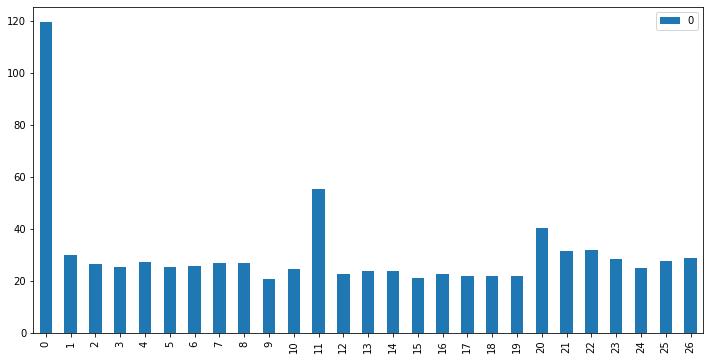

In [162]:
abstract_paths, abstract_info = get_file_from_pattern(abstract_dir, pattern)
pd.DataFrame(abstract_info).plot.bar(figsize=(12, 6))
print(f"Total size of redirect files : {np.sum(info):.2f} MB")

### loading saved file information

In [9]:
import re

data_paths = []
file_info = []

prog = re.compile(f'{project}-{dump_date}-pages-articles-multistream'+r'')
for file in os.listdir(f'{dataset_home}/datasets'):
    if prog.match(file):
        path = f'{dataset_home}/datasets/{file}'
        
        data_paths.append(path)
        file_size = os.stat(path).st_size/1e6
        file_articles = int(file.split('p')[-1].split('.')[0]) - int(file.split('p')[-2])
        file_info.append((file, file_size, file_articles))

### size of the files

In [6]:
pd.DataFrame(sorted(file_info, key=lambda x: x[1], reverse=True)[:4], columns=['filename', 'size (MB)', '--'])

,filename,size (MB),--
0,enwiki-20220420-pages-articles-multistream9.xm...,556.144802,1109141
1,enwiki-20220420-pages-articles-multistream10.x...,549.290108,1353963
2,enwiki-20220420-pages-articles-multistream11.x...,533.662197,1499999
3,enwiki-20220420-pages-articles-multistream8.xm...,512.258438,802148


In [7]:
print(f"Number of partitions : {len(file_info)}")

Number of partitions : 62


'/home/scai/phd/aiz218323/scratch/XML/wikipedia-data-science//datasets/'

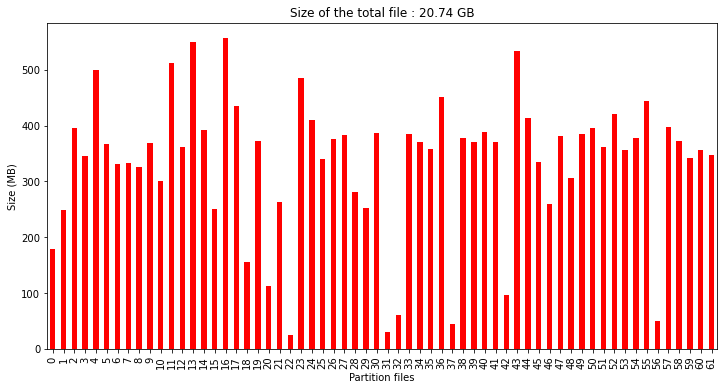

In [14]:
file_info_df = pd.DataFrame(file_info, columns=['filename', 'size (MB)', '--'])
file_info_df['size (MB)'].plot.bar(color='red', figsize=(12, 6))
plt.xlabel('Partition files')
plt.ylabel('Size (MB)')
plt.title(f"Size of the total file : {file_info_df['size (MB)'].sum()/1e3:.2f} GB")
plt.savefig(f'{dataset_home}/data/wikidump.jpg')

In [8]:
print(f"Size of the total file : {file_info_df['size (MB)'].sum()/1e3:.2f} GB")

Size of the total file : 20.74 GB


## Parsing the Dump

Parsing approach

1. Extract XML information.
2. Extract wikipedia related information from the XML elements.

In [10]:
import mwparserfromhell
mwparserfromhell.__version__

'0.7.dev0'

In [11]:
import bz2
import subprocess

data_path = data_paths[15]
data_path

'/home/cse/phd/anz198717/scratch/suchith_data/wikipedia/wikipedia-data-science/datasets/enwiki-20220420-pages-articles-multistream13.xml-p10672789p11659682.bz2'

### bz2 vs bzcat

In [21]:
%%timeit -n 3 -r 3

lines = []
for i, line in enumerate(bz2.BZ2File(data_path, 'r')):
    lines.append(line)
    if i > 1e6:
        break

3.72 s ± 32.7 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [22]:
%%timeit -n 3 -r 3

lines = []
for i, line in enumerate(subprocess.Popen(['bzcat'],
                                         stdin = open(data_path),
                                         stdout = subprocess.PIPE).stdout):
    lines.append(line)
    if i > 1e6:
        break

2.36 s ± 5.15 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [149]:
lines = []
for i, line in enumerate(subprocess.Popen(['bzcat'],
                                         stdin = open(data_path),
                                         stdout = subprocess.PIPE).stdout):
    lines.append(line)
    if i > 1e6:
        break

In [150]:
for i, l in enumerate(lines[0:150]):
    print(i, l)

0 b'<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.10/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.10/ http://www.mediawiki.org/xml/export-0.10.xsd" version="0.10" xml:lang="en">\n'
1 b'  <siteinfo>\n'
2 b'    <sitename>Wikipedia</sitename>\n'
3 b'    <dbname>enwiki</dbname>\n'
4 b'    <base>https://en.wikipedia.org/wiki/Main_Page</base>\n'
5 b'    <generator>MediaWiki 1.38.0-wmf.19</generator>\n'
6 b'    <case>first-letter</case>\n'
7 b'    <namespaces>\n'
8 b'      <namespace key="-2" case="first-letter">Media</namespace>\n'
9 b'      <namespace key="-1" case="first-letter">Special</namespace>\n'
10 b'      <namespace key="0" case="first-letter" />\n'
11 b'      <namespace key="1" case="first-letter">Talk</namespace>\n'
12 b'      <namespace key="2" case="first-letter">User</namespace>\n'
13 b'      <namespace key="3" case="first-letter">User talk</namespace>\n'
14 b'      <namespace key="4" case="first-let

In [151]:
pages = lines[59:79]
pages

[b'  <page>\n',
 b'    <title>Ripcot</title>\n',
 b'    <ns>0</ns>\n',
 b'    <id>10672797</id>\n',
 b'    <redirect title="The Ripping Friends" />\n',
 b'    <revision>\n',
 b'      <id>122987209</id>\n',
 b'      <parentid>122881505</parentid>\n',
 b'      <timestamp>2007-04-15T14:23:39Z</timestamp>\n',
 b'      <contributor>\n',
 b'        <username>RHaworth</username>\n',
 b'        <id>161142</id>\n',
 b'      </contributor>\n',
 b'      <comment>[[WP:AES|\xe2\x86\x90]]Redirected page to [[The Ripping Friends]]</comment>\n',
 b'      <model>wikitext</model>\n',
 b'      <format>text/x-wiki</format>\n',
 b'      <text bytes="33" xml:space="preserve">#redirect [[The Ripping Friends]]</text>\n',
 b'      <sha1>biyizsvwopzalozl09xwmyrmd39vu3n</sha1>\n',
 b'    </revision>\n',
 b'  </page>\n']

### SAX XML Parser

In [6]:
class WikiXmlHandler(xml.sax.handler.ContentHandler):
    
    def __init__(self):
        xml.sax.handler.ContentHandler.__init__(self)
        self._buffer = None
        self._values = {}
        self._current_tag = None
        self._pages = []
        
        self._add_page = False
        
    def characters(self, content):
        if self._current_tag:
            self._buffer.append(content)
            
    def startElement(self, name, attrs):
        if name in ('title', 'text', 'timestamp', 'id', 'ns'):
            self._current_tag = name
            self._buffer = []
            
    def endElement(self, name):
        if name == self._current_tag:
            self._values[name] = ' '.join(self._buffer)
            self._current_tag = None
            
            if name == 'ns':
                self._add_page = True if int(self._values['ns']) == 0 else False
                
        elif name == 'page' and self._add_page:
            self._add_page = False
            self._pages.append( (self._values['title'], self._values['text'], self._values['id']) )

In [27]:
handler = WikiXmlHandler()

parser = xml.sax.make_parser()
parser.setContentHandler(handler)

handler._pages

[]

#### __Parsing a page__

In [41]:
for l in pages:
    parser.feed(l)

In [42]:
handler._pages

[('Ripcot', '#redirect [[The Ripping Friends]]', '161142')]

#### __Putting it all together__

In [43]:
handler = WikiXmlHandler()

parser = xml.sax.make_parser()
parser.setContentHandler(handler)

for i, line in enumerate(subprocess.Popen(['bzcat'],
                                         stdin=open(data_path),
                                         stdout=subprocess.PIPE).stdout):
    parser.feed(line)
    
    if len(handler._pages) > 3:
        break

In [44]:
[ (page[0], page[2]) for page in handler._pages ]

[('Rational inference', '846078'),
 ('Ripcot', '161142'),
 ('Dorsa Whiston', '1369254'),
 ('Delphic of Gamma Sigma Tau Fraternity', '82835')]

### Parsing Articles `mwparserfromhell`

Read 50 articles from the dump.

In [14]:
handler = WikiXmlHandler()

parser = xml.sax.make_parser()
parser.setContentHandler(handler)

for i, line in enumerate(subprocess.Popen(['bzcat'],
                                         stdin=open(data_path),
                                         stdout=subprocess.PIPE).stdout):
    parser.feed(line)
    
    if len(handler._pages) > 50:
        break

In [15]:
pd.DataFrame(handler._pages[0:10])

,0,1,2
0,Dorsa Whiston,'''Dorsa Whiston''' is a [[wrinkle ridge]] sys...,10672809
1,Humor Monastery,[[Image:Rares.jpg|thumb|Petru Rareş]] \n '''Hu...,10672850
2,Tir na n-Og Award,{{Use dmy dates|date=April 2022}} \n The '''Ti...,10672900
3,"Barrington Passage, Nova Scotia","{{distinguish|Barrington, Nova Scotia (disambi...",10672928
4,University of Wisconsin–Milwaukee College of E...,{{Infobox university \n |image= < !-- Do NOT p...,10672963
5,University of Wisconsin–Milwaukee School of Ed...,{{Infobox university \n |image= < !-- Do NOT ...,10672987
6,Loiner,{{Short description|Demonym for a citizen of L...,10673017
7,Standin' on the Corner Park,"{{short description|Public park in Winslow, Ar...",10673030
8,The Adventurers (1970 film),{{short description|1970 film}} \n {{Use mdy d...,10673063
9,Stéphane Haccoun,{{short description|French boxer}} \n {{Use dm...,10673064


In [16]:
page_num = 2
print(handler._pages[page_num][0])

wiki = mwparserfromhell.parse(handler._pages[page_num][1])

Tir na n-Og Award


#### Parsing the wikicode

##### wikilinks

In [48]:
wikilinks = [x.title for x in wiki.filter_wikilinks()]
print(f"There are {len(wikilinks)} wikilinks present.")
wikilinks

There are 10 wikilinks present.


['demonym',
 'Leeds',
 'Rugby league',
 'Leeds Rhinos',
 'Yorkshire Evening Post',
 'Joseph Wright (linguist)',
 'Windhill and Wrose',
 'English Dialect Dictionary',
 'Category:People from Leeds',
 'Category:Demonyms']

##### externallinks

In [49]:
externallinks = [(x.title, x.url) for x in wiki.filter_external_links()]
print(f"There are {len(externallinks)} external links present.")
externallinks

There are 3 external links present.


[(None,
  'http://www.yorkshireeveningpost.co.uk/sport/rugby-league/leeds-rhinos/leeds-rhinos-flashback-loiners-come-back-from-the-dead-to-beat-saints-and-retain-the-cup-1-7253506'),
 (None, 'https://englandsnortheast.co.uk/yorkshire-leeds-west-yorkshire'),
 (None,
  'https://www.bbc.co.uk/leeds/content/articles/2005/01/06/voices2005_loiner_feature.shtml')]

##### templates

In [62]:
templates = wiki.filter_templates()
for template in templates:
    print(template.name, " : ", template.params)

Short description  :  ['Demonym for a citizen of Leeds, England']
Use dmy dates  :  ['date=November 2019']
cite news  :  ['url=http://www.yorkshireeveningpost.co.uk/sport/rugby-league/leeds-rhinos/leeds-rhinos-flashback-loiners-come-back-from-the-dead-to-beat-saints-and-retain-the-cup-1-7253506', 'work=[[Yorkshire Evening Post]]', 'title=Leeds Rhinos Flashback: Loiners come back from the dead to beat Saints and retain the Cup', 'first=Peter', 'last=Smith', 'date=11 May 2015']
cite web  :  ['url=https://englandsnortheast.co.uk/yorkshire-leeds-west-yorkshire', 'website=www.englandsnortheast.co.uk', 'title=LEEDS AND WEST YORKSHIRE', 'accessdate=12 November 2018']
cite web  :  ['url=https://www.bbc.co.uk/leeds/content/articles/2005/01/06/voices2005_loiner_feature.shtml', 'work=BBC voices2005', 'title=Loiners of the world unite!', 'date=24 September 2014', 'accessdate =12 November 2018']
reflist  :  []


##### sections

In [282]:
wiki = mwparserfromhell.parse(handler._pages[page_num][1])

['[', '[', 'Image', ':', 'GottliebOtt.jpg', '|', 'right', '|', 'thumb', '|', '250px', '|', 'A picture of Gottlieb Ott, Swiss building contractor', ']', ']', ' ', '\n', ' ', "'", "'", "'", 'Gottlieb Ott', "'", "'", "'", ' (1832, ', '[', '[', 'Worb', ']', ']', '  ', '&', ' ndash', ';', ' 4 December 1882) was a ', '[', '[', 'Switzerland', '|', 'Swiss', ']', ']', ' ', '[', '[', 'general contractor', '|', 'building contractor', ']', ']', '. Ott and his company are credited with planning and constructing many buildings and structures in and around ', '[', '[', 'Bern', ']', ']', ', including the ', '[', '[', 'church field bridge', ']', ']', '. He also supervised the removal of the ', '[', '[', 'Christoffelturm', ']', ']', ', a local tower built in the 14th century. ', '\n', ' ', '\n', ' ', '=', '=', 'Life and family history', '=', '=', ' ', '\n', ' Ott', "'", 's great grandfather had migrated from ', '[', '[', 'Swabia', ']', ']', ' in ', '[', '[', 'Germany', ']', ']', ' to ', '[', '[', 'Jegen

In [283]:
sections = wiki.get_sections()
len(sections)

5

For some reason the sections are not being detected. So, lets investigate:

In [187]:
"""
handler = WikiXmlHandler()

parser = xml.sax.make_parser()
parser.setContentHandler(handler)

prev_num_pages = 0
for i, line in enumerate(subprocess.Popen(['bzcat'],
                                         stdin=open(data_path),
                                         stdout=subprocess.PIPE).stdout):
    parser.feed(line)
    
    if prev_num_pages < len(handler._pages):
        prev_num_pages += 1
        wiki = mwparserfromhell.parse(handler._pages[-1][1], skip_style_tags=True)
        sections = wiki.get_sections()
        if len(sections) > 3:
            break
"""
pass

This code is failing badly and not detecting sections at all.

In [284]:
page = handler._pages[page_num][1]
page

"[[Image:GottliebOtt.jpg|right|thumb|250px|A picture of Gottlieb Ott, Swiss building contractor]] \n '''Gottlieb Ott''' (1832, [[Worb]]  & ndash; 4 December 1882) was a [[Switzerland|Swiss]] [[general contractor|building contractor]]. Ott and his company are credited with planning and constructing many buildings and structures in and around [[Bern]], including the [[church field bridge]]. He also supervised the removal of the [[Christoffelturm]], a local tower built in the 14th century. \n \n ==Life and family history== \n Ott's great grandfather had migrated from [[Swabia]] in [[Germany]] to [[Jegenstorf]] in 1782, and it was his grandfather who established the Otts in [[Worb]]. Ott's schooling was based in Bern, and he later studied at the polytechnic institute of [[Karlsruhe]]. After he finished his studies < !--in XXXXX(year?)-- > , he dabbled in several enterprises before opening a private [[construction]] company.  In 1864, this company evolved into ''Ott  &  Cie'', which would b

In [286]:
wiki = mwparserfromhell.parse(page, skip_style_tags=True)

for i, n in enumerate(wiki.nodes):
    print(i, n)

0 [[Image:GottliebOtt.jpg|right|thumb|250px|A picture of Gottlieb Ott, Swiss building contractor]]
1  
 '''Gottlieb Ott''' (1832, 
2 [[Worb]]
3   & ndash; 4 December 1882) was a 
4 [[Switzerland|Swiss]]
5  
6 [[general contractor|building contractor]]
7 . Ott and his company are credited with planning and constructing many buildings and structures in and around 
8 [[Bern]]
9 , including the 
10 [[church field bridge]]
11 . He also supervised the removal of the 
12 [[Christoffelturm]]
13 , a local tower built in the 14th century. 
 
 
14 ==Life and family history==
15  
 Ott's great grandfather had migrated from 
16 [[Swabia]]
17  in 
18 [[Germany]]
19  to 
20 [[Jegenstorf]]
21  in 1782, and it was his grandfather who established the Otts in 
22 [[Worb]]
23 . Ott's schooling was based in Bern, and he later studied at the polytechnic institute of 
24 [[Karlsruhe]]
25 . After he finished his studies < !--in XXXXX(year?)-- > , he dabbled in several enterprises before opening a private 
26 

In [287]:
wiki.remove_nodetype(inplace=True)

In [288]:
wiki.nodes

['[[Image:GottliebOtt.jpg|right|thumb|250px|A picture of Gottlieb Ott, Swiss building contractor]]',
 " \n '''Gottlieb Ott''' (1832, ",
 '[[Worb]]',
 '  & ndash; 4 December 1882) was a ',
 '[[Switzerland|Swiss]]',
 ' ',
 '[[general contractor|building contractor]]',
 '. Ott and his company are credited with planning and constructing many buildings and structures in and around ',
 '[[Bern]]',
 ', including the ',
 '[[church field bridge]]',
 '. He also supervised the removal of the ',
 '[[Christoffelturm]]',
 ', a local tower built in the 14th century. \n \n ',
 '==Life and family history==',
 " \n Ott's great grandfather had migrated from ",
 '[[Swabia]]',
 ' in ',
 '[[Germany]]',
 ' to ',
 '[[Jegenstorf]]',
 ' in 1782, and it was his grandfather who established the Otts in ',
 '[[Worb]]',
 ". Ott's schooling was based in Bern, and he later studied at the polytechnic institute of ",
 '[[Karlsruhe]]',
 '. After he finished his studies < !--in XXXXX(year?)-- > , he dabbled in several ent

##### Looing at different headings in the wikipedia pages

In [33]:
from timeit import default_timer as timer

start = timer()

handler = WikiXmlHandler()
parser = xml.sax.make_parser()
parser.setContentHandler(handler)

headings = set()
prev_num_pages = 0
for i, line in enumerate(subprocess.Popen(['bzcat'],
                                          stdin=open(data_path),
                                          stdout=subprocess.PIPE).stdout):
    try:
        parser.feed(line)
    except StopIteration:
        break
    parser.feed(line)
    
    """
    if len(handler._pages) > 1e6:
        break
    """
    if prev_num_pages < len(handler._pages):
        prev_num_pages += 1
        wiki = mwparserfromhell.parse(handler._pages[-1][1])
        for h in wiki.filter_headings():
            headings.add(h.title.strip_code().strip())
            
end = timer()
print(f'Time taken : {round(end - start)} seconds.')

Time taken : 4363 seconds.


###### see all case

In [35]:
for i, p in enumerate(handler._pages):
    wiki = mwparserfromhell.parse(p[1])
    for h in wiki.filter_headings():
        if "see all" == h.title.strip_code().strip().lower():
            print(i)
            break

118354


In [39]:
wiki = mwparserfromhell.parse(handler._pages[118354][1])
wiki.get_sections()

["{{About|the'''JusticeDenied'''magazine|thebookorfilmofthesamename|DonaldMarshall,Jr.|the''[[Law&Order:SpecialVictimsUnit]]''episode|JusticeDenied(Law&Order:SpecialVictimsUnit)}}\n{{refimprove|date=August2009}}\n'''''JusticeDenied''''' is the only regularly published print magazine in the world solely devoted to issues related to wrongful convictions. The magazine prints stories about wrongful convictions, [[Miscarriageofjustice|miscarriagesofjustice]], and [[criminaljustice]] issues related to [[Prosecutor|prosecution]] and [[conviction]] of [[Innocence|innocent]] people in countries around the world. < ref > Justicedenied.org:[http://justicedenied.org/about.htm AboutJD]</ref >\n\n",
 "==Details==\n''JusticeDenied'' was founded in 1998 as a volunteer, [[Non-profitorganization|non-profit]] magazine to promote awareness of wrongful convictions, and their causes and preventions. Its first issue was in February 1999, and the two original co-publishers were Stormy Thoming-Gale and Clara B

###### section beginning with "see"

In [36]:
start_with_s = []

for h in sorted(headings):
    if 'see' == h.lower().strip()[:3]:
        start_with_s.append(h)

In [37]:
start_with_s

['SEECO Records',
 'See',
 'See  also',
 'See Also',
 'See Also (Social reformers of Kerala)',
 'See More',
 'See all',
 'See also',
 'Seed spitting',
 'Seed treatment',
 'Seeding',
 'Seeding and draw',
 'Seeding and pollination',
 'Seeding and pool draw',
 'Seeding and runners-up',
 'Seedings and format',
 'Seeds',
 'Seedsnipes',
 'Seegrotte',
 'Seeing Stars (1993)',
 "Seeing the condemned man's photo, his mother insists on traveling to see him",
 'Seeley Booth',
 'Seepromenade Krumpendorf  &  Waldarena']

## Creating graphs from wikilinks

#### Modified Content handler for redirects

In [13]:
class WikiXmlHandler(xml.sax.handler.ContentHandler):
    
    def __init__(self):
        xml.sax.handler.ContentHandler.__init__(self)
        self._buffer = None
        self._values = {}
        self._current_tag = None
        self._pages = []
        
        self._redirects = {}
        self._add_page = True
        self._is_pageid = True
        
    def characters(self, content):
        if self._current_tag:
            self._buffer.append(content)
            
    def startElement(self, name, attrs):
        if name in ('title', 'text', 'ns'):
            self._current_tag = name
            self._buffer = []
        elif name == 'id' and self._is_pageid:
            self._is_pageid = False
            self._current_tag = name
            self._buffer = []    
        elif name == 'redirect':
            self._redirects[self._values['title']] = attrs.getValue('title').strip()
            self._add_page = False
                    
    def endElement(self, name):
        if name == self._current_tag:
            self._values[name] = ' '.join(self._buffer)
            self._current_tag = None
                
        elif name == 'page':
            if int(self._values['ns']):
                self._add_page = False
                
            if self._add_page:
                self._pages.append( (self._values['title'], self._values['text'], self._values['id']) )
            
            self._add_page = True
            self._is_pageid = True
            

### Search for wikilinks

extract links other than template links and see also links.

In [67]:
def get_filtered_wikilinks(sections):
    wikilinks = list()
    
    for section in sections:
        links = section.filter_wikilinks()
        
        for link in links:
            link_title = link.title

            link_parts = link_title.split(':')
            link_parts[0] = link_parts[0].strip()

            if len(link_parts) == 1:
                wikilinks.append(link_parts[0])
            elif len(link_parts) == 2 and not link_parts[0]:
                wikilinks.append(link_parts[1].strip())
                
    return wikilinks

In [68]:
def get_filtered_wikilinks(sections):
    wikilinks = list()
    
    for section in sections:
        links = list( map(lambda link: (link.title).strip_code().strip(), section.filter_wikilinks()) )
        wikilinks.extend(links)
                
    return wikilinks

In [17]:
wiki_prefix = {'user', 'file', 'mediawiki', 'template', 'help', 'category', 
                  'portal', 'draft', 'timedtext', 'module', 'special', 'media', 
                  'cat', 'h', 'mos', 'p', 't', 'project', 'image', 'wikipedia',
               'wp', 'ru', 'wikt', 's', 'fr', 'el', 'es', 'c', 'commons'
              }

In [131]:
def filter_wikilink(link, page_title):
    link = (link.title).strip_code()
    if not link:
        return None

    """
    link starting with :
    """
    if link[0] == ':':
        link = link[1:]

    """
    filter links based on prefixes
    """ 
    link_sections = link.split(':', 1)
    while len(link_sections) > 1 and link_sections[0] in ["w", "en"]:
        link_sections = link_sections[1].split(':', 1)
    link = link_sections[0] if len(link_sections) == 1 else ':'.join(link_sections)

    if ':' in link:
        prefix, suffix = link.split(':', 1)
        if prefix.lower().strip() in wiki_prefix:
            return None

    """
    removing section link
    """
    if '#' in link:
        link, _ = link.split('#', 1)
        link = link.strip()
        if not link:
            link = page_title

    """
    '_' is equivalent to ' ' in the link.
    first letter of link is case insensitive
    """
    link = link.replace('_', ' ')
    
    if not link:
        return None
    
    return link[0].lower() + link[1:]

In [133]:
def get_filtered_wikilinks(sections, page_title):
    wikilinks = list()
    
    for section in sections:
        for link in section.filter_wikilinks():
            f_link = filter_wikilink(link, page_title)
            if f_link:
                wikilinks.append(f_link)
            
    return wikilinks

In [134]:
def process_article(page_title, page_text, page_id, page_ns, matches):
    
    wikicode = mwparserfromhell.parse(page_text, skip_style_tags=True)
    wikicode.remove_nodetype(inplace=True)
    
    match_sections, all_sections = wikicode.split_sections(matches=matches, include_lead=True)
    
    match_sec_wikilinks = get_filtered_wikilinks(match_sections, page_title)
    all_sec_wikilinks = get_filtered_wikilinks(all_sections, page_title)
    
    text_content = wikicode.strip_code().strip()

    return (page_title.strip(), match_sec_wikilinks, all_sec_wikilinks, text_content, int(page_id.strip()))

In [135]:
matches = r'^([Ss]ee[ ]*|[Ss]ee[ ]*([Aa]lso|[Mm]ore|[Aa]ll)|[Ss]ee[ ]*[Aa]lso[ ]*\(.+\))$'

#### Testing the above code

In [126]:
handler._values.keys()

dict_keys(['title', 'ns', 'id', 'text'])

In [127]:
page = handler._pages[50]; page

('Rania, Sirsa',
 '{{more citations needed|date=September 2016}} \n {{Use dmy dates|date=December 2019}} \n {{Use Indian English|date=October 2017}} \n {{Infobox settlement \n | name                    = Rania \n | native_name             =  \n | native_name_lang        =  \n | other_name              =  \n | nickname                =  \n | settlement_type         = Town < ref > {{cite web |title=Towns {{!}} Sirsa {{!}} India |url=https://sirsa.gov.in/towns/ |website=sirsa.gov.in |access-date=27 September 2020}} < /ref > \n | image_skyline           =  \n | image_alt               =  \n | image_caption           =  \n | pushpin_map             = India Haryana#India3 \n | pushpin_label_position  = right \n | pushpin_map_alt         =  \n | pushpin_map_caption     = Location in Haryana, India \n | coordinates             = {{coord|29.53|N|74.83|E|display=inline,title}} \n | subdivision_type        = Country \n | subdivision_name        = {{flag|India}} \n | subdivision_type1       = [[St

In [136]:
title, seealso, pagelink, _, _ = process_article(*page, 0, matches)

In [137]:
title, seealso, len(list(np.unique(pagelink)))

('Rania, Sirsa', [], 68)

In [138]:
pagelink

['sirsa district',
 'india',
 'states and territories of India',
 'haryana',
 'grain trade',
 'sati (practice)',
 "nader Shah's invasion of the Mughal Empire",
 'bhatti clan',
 'ranghar',
 'rajput',
 'jat people',
 'sikh',
 'patiala State',
 'jind State',
 'johiya',
 'paragana',
 'bikaner State',
 'bhatner fort',
 'hanumangarh',
 'mughal empire',
 'mirza Najaf Khan',
 'jaipur State',
 'tosham',
 'hisar (city)',
 'hansi',
 'meham',
 'rohtak',
 'sarkar (country subdivision)',
 'narwana',
 'jind',
 'kaithal',
 'shah Alam II',
 'maratha empire',
 'mahadaji Shinde',
 'george Thomas (soldier)',
 'daulat Rao Sindhia',
 'pierre Cuillier-Perron',
 'british raj',
 'baoli',
 'turkish bath',
 'water well',
 'the Emergency (India)',
 'british Raj',
 'william Fraser (British India civil servant)',
 'james Baillie Fraser',
 'william Dalrymple (historian)',
 'indian Rebellion of 1857',
 'nahar Singh',
 'jat people',
 'rao Tula Ram',
 'rewari',
 'partition of India',
 'fort',
 'punjab Region',
 'haryan

### Modified Content handler for text processing

In [6]:
class WikiXmlHandler(xml.sax.handler.ContentHandler):
    
    def __init__(self, matches=None):
        xml.sax.handler.ContentHandler.__init__(self)
        self.matches = matches
        """
        basic storage for on-the-fly processing
        """
        self._buffer = None
        self._values = {}
        self._current_tag = None
        """
        flags for handling special cases.
        """
        self._add_page = True
        self._is_pageid = True
        """
        dump statistics
        """
        self._total_edges = 0
        self._article_count = 0
        """
        output information
        """
        self.graph = {}
        self.seealso = {}
        self.redirects = {}
        self.id_to_title = {}
        self.page_content = {}
        
        
    def characters(self, content):
        if self._current_tag:
            self._buffer.append(content)
            
    def startElement(self, name, attrs):
        if name in ('title', 'text', 'ns'):
            self._current_tag = name
            self._buffer = []
        elif name == 'id' and self._is_pageid:
            self._is_pageid = False
            self._current_tag = name
            self._buffer = []    
        elif name == 'redirect':
            self.redirects[self._values['page_title'].strip()] = attrs.getValue('title').strip()
            self._add_page = False
                   
    def endElement(self, name):
        if name == self._current_tag:
            self._values[f'page_{name}'] = ' '.join(self._buffer)
            self._current_tag = None
        elif name == 'page':
            if int(self._values['page_ns']):
                self._add_page = False
                
            if self._add_page:
                self._article_count += 1
                """
                text processing
                """
                proc_output = process_article(**self._values, matches=self.matches)
                self.graph_processing(*proc_output)
                
            self._add_page = True
            self._is_pageid = True
            
    def graph_processing(self, title, seealso_wikilinks, page_wikilinks, text_content, page_id):
        if len(seealso_wikilinks) or len(page_wikilinks):
            self.id_to_title[page_id] = title
            if len(seealso_wikilinks):
                links, count = np.unique(seealso_wikilinks, return_counts=True)
                self.seealso[page_id] = (links.tolist(), count.tolist())
            if len(page_wikilinks):
                self._total_edges += len(page_wikilinks)
                links, count = np.unique(page_wikilinks, return_counts=True)
                self.graph[page_id] = (links.tolist(), count.tolist())
            if text_content:
                self.page_content[page_id] = text_content

#### testing the above code

In [32]:
matches = r'^([Ss]ee[ ]*|[Ss]ee[ ]*([Aa]lso|[Mm]ore|[Aa]ll)|[Ss]ee[ ]*[Aa]lso[ ]*\(.+\))$'

In [33]:
from timeit import default_timer as timer

start = timer()

handler = WikiXmlHandler(matches)

parser = xml.sax.make_parser()
parser.setContentHandler(handler)

for i, line in enumerate(subprocess.Popen(['bzcat'], 
                         stdin = open(data_path), 
                         stdout = subprocess.PIPE).stdout):
    parser.feed(line)
    
    if handler._article_count > 1e3:
        break
        
end = timer()
        
print(f'Searched through {handler._article_count} articles.')
print(f'Processing time is {round(end - start)} secs.')
print(f'\nNumber of nodes and edges in the graph is {len(handler.graph)} and {handler._total_edges}.')

Searched through 1001 articles.
Processing time is 24 secs.

Number of nodes and edges in the graph is 1001 and 44423.


In [34]:
len(handler.id_to_title.values()), len(set(handler.id_to_title.values())), len(handler.graph), len(handler.seealso)

(1001, 1001, 1001, 229)

In [35]:
handler.seealso[10679966]

['Higher education in Portugal', 'Independente University']

In [36]:
handler.id_to_title[10679966]

'Moderna University'

In [37]:
handler.graph[10679966]

['Portugal',
 'private university',
 'Lisbon',
 'Setúbal',
 'Porto',
 'Beja (Portugal)',
 'Diário de Notícias']

In [38]:
handler.redirects

{'Rational inference': 'Inference',
 'Ripcot': 'The Ripping Friends',
 'Delphic of Gamma Sigma Tau Fraternity': 'Delphic Fraternity',
 'Tir na n-og Awards': 'Tir na n-Og Award',
 'Chantiers de l’Atlantique': "Chantiers de l'Atlantique",
 'South Australian general election campaign, 2006': '2006 South Australian state election',
 'Sr. Maria Stanisia': 'Mary Stanisia',
 'Monica Kurkowski': 'Mary Stanisia',
 'Atlantoaxial': 'Atlanto-axial joint',
 'URGI': 'Avenue (store)',
 'Panagiotis Fassoulas': 'Panagiotis Fasoulas',
 'Dysplasia of the hip': 'Hip dysplasia',
 'Uk.yahoo.com': 'Yahoo!',
 'Twilight of the idols': 'Twilight of the Idols',
 'Factions in Supreme Commander': 'Supreme Commander (video game)',
 'Tir na n-Og awards': 'Tir na n-Og Award',
 'Thon the Egyptian': 'Polydamna',
 'Egg Harbor City (NJT Station)': 'Egg Harbor City station',
 'Nyrondal': 'Greyhawk',
 'William M. Fowler, Jr.': 'William M. Fowler',
 'Allendale (NJT Station)': 'Allendale station (NJ Transit)',
 'Independent 

#### Time taken to process a full partition

In [11]:
dataset_home, data_path

('/home/scai/phd/aiz218323/scratch/XML/wikipedia-data-science/',
 '/home/scai/phd/aiz218323/scratch/XML/wikipedia-data-science//datasets/enwiki-20220420-pages-articles-multistream13.xml-p10672789p11659682.bz2')

In [12]:
# Uncompress the file if not already uncompressed
if not os.path.exists('/home/scai/phd/aiz218323/scratch/XML/wikipedia-data-science/datasets/p15.xml'):
    subprocess.call(['bzcat /home/scai/phd/aiz218323/scratch/XML/wikipedia-data-science//datasets/enwiki-20220420-pages-articles-multistream13.xml-p10672789p11659682.bz2 >> /home/scai/phd/aiz218323/scratch/XML/wikipedia-data-science/datasets/p15.xml'],
                    shell = True)
else:
    print('Already uncompressed')

Already uncompressed


In [13]:
!wc /home/scai/phd/aiz218323/scratch/XML/wikipedia-data-science/datasets/p15.xml

  15773944  106458167 1016082707 /home/scai/phd/aiz218323/scratch/XML/wikipedia-data-science/datasets/p15.xml


In [14]:
from timeit import default_timer as timer

start = timer()

handler = WikiXmlHandler(matches)

parser = xml.sax.make_parser()
parser.setContentHandler(handler)

for i, line in enumerate(subprocess.Popen(['bzcat'], 
                         stdin = open(data_path), 
                         stdout = subprocess.PIPE).stdout):
    if (i + 1) % 10000 == 0:
        print(f'Processed {i + 1} lines so far.', end = '\r')
    try:
        parser.feed(line)
    except StopIteration:
        break
    
    """
    testing code
    
    if handler._article_count > 1e4:
        break

    testing code
    """
    
end = timer()

print(f'\nSearched through {handler._article_count} articles.')
print(f'Number of nodes and edges in the graph is {len(handler.graph)} and {handler._total_edges}.')
print(f'\nDump processed in {round(end - start)} seconds.')

Processed 15770000 lines so far.
Searched through 84288 articles.
Number of nodes and edges in the graph is 83990 and 4048208.

Dump processed in 2163 seconds.


##### exploration

In [50]:
len(handler.id_to_title), len(handler.graph), len(handler.seealso)

(1001, 1001, 229)

In [51]:
handler.id_to_title[10672900]

'Tir na n-Og Award'

In [52]:
handler.graph

{10672809: (['Apollo 15',
   'Moon',
   'Oceanus Procellarum',
   'William Whiston',
   'wrinkle ridge'],
  [1, 1, 1, 1, 1]),
 10672850: (['Churches of Moldavia',
   'Dormition',
   'Gura Humorului',
   'Moldavia',
   'Mănăstirea Humorului',
   'Petru Rareş',
   'Romania',
   'Sergius I of Constantinople',
   'Teodor Bubuiog',
   'Theotokos',
   'UNESCO',
   'Voronet Monastery (Bucovina, Romania)',
   'World Heritage Sites',
   'monastery'],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1]),
 10672900: (['A String in the Harp',
   'Adref Heb Elin',
   'Alun Jones (writer)',
   'Alun Wyn Bevan',
   'Alwena’s Garden',
   'American Library Association',
   'Angharad Tomos',
   'Anne Lewis (writer)',
   'Annwyl Smotyn Bach',
   'Artworks On ... Interiors',
   'Battle of Passchendaele',
   'Ben y Garddwr a Storïau Eraill',
   'Bethan Gwanas',
   'Bethan Wyn Jones',
   'Bette Meyrick',
   'Bluestones (novel)',
   'Books Council of Wales',
   'Bownsio',
   'Broc Môr',
   'Byd Llawn Hud',
   'Byw 

In [53]:
handler.seealso

{10672928: (['List of communities in Nova Scotia'], [1]),
 10672963: (['Jantar-Mantar'], [1]),
 10673063: (['List of American films of 1970'], [1]),
 10673064: (['List of Jews in sports#Boxers'], [1]),
 10673610: (['LGBT social movements',
   'List of protest marches on Washington, D.C.',
   'March on Washington for Lesbian, Gay and Bi Equal Rights and Liberation',
   'Millennium March on Washington',
   'National Equality March',
   'National Pride March',
   'Second National March on Washington for Lesbian and Gay Rights'],
  [1, 1, 1, 1, 1, 1, 1]),
 10673627: (['Grand Avenue (disambiguation)',
   'Grand Boulevard (disambiguation)'],
  [1, 1]),
 10673633: (['List of protest marches on Washington, D.C.',
   'March on Washington for Lesbian, Gay and Bi Equal Rights and Liberation',
   'Millennium March on Washington',
   'National Coming Out Day',
   'National Equality March',
   'National March on Washington for Lesbian and Gay Rights',
   'National Pride March'],
  [1, 1, 1, 1, 1, 1,

In [58]:
handler.graph[10673633][0]

['ACT UP',
 'AIDS',
 'Atlanta',
 'Bowers v. Hardwick',
 'Cesar Chavez',
 'Demonstration (people)',
 'Eleanor Smeal',
 'HIV',
 'Internal Revenue Service',
 'Jesse Jackson',
 'Judy Tallwing McCarthey',
 'LGBT',
 "Lani Ka'ahumanu",
 'NAMES Project AIDS Memorial Quilt',
 'Nancy Pelosi',
 'National Coming Out Day',
 'National Gay and Lesbian Task Force',
 'National March on Washington for Lesbian and Gay Rights',
 'National Organization for Women',
 'North American Bisexual Network',
 'Pat Norman (activist)',
 'Reproductive rights',
 'Ronald Reagan',
 'Sexism',
 'Supreme Court of the United States',
 'United States Supreme Court Building',
 'United States Supreme Court building',
 'Washington, D.C.',
 'Whoopi Goldberg',
 'apartheid',
 'civil disobedience',
 'leather subculture',
 'racism']

In [59]:
handler.seealso[10673633][0]

['List of protest marches on Washington, D.C.',
 'March on Washington for Lesbian, Gay and Bi Equal Rights and Liberation',
 'Millennium March on Washington',
 'National Coming Out Day',
 'National Equality March',
 'National March on Washington for Lesbian and Gay Rights',
 'National Pride March']

#### Write to a file

In [15]:
import json

In [16]:
with open(f'{dataset_home}/data/p15_graph.ndjson', 'wt') as fout:
    fout.write( json.dumps(handler.graph) )
    
with open(f'{dataset_home}/data/p15_seealso.ndjson', 'wt') as fout:
    fout.write( json.dumps(handler.seealso) )
    
with open(f'{dataset_home}/data/p15_redirects.ndjson', 'wt') as fout:
    fout.write( json.dumps(handler.redirects) )
    
with open(f'{dataset_home}/data/p15_id-to-title.ndjson', 'wt') as fout:
    fout.write( json.dumps(handler.id_to_title) )
    
with open(f'{dataset_home}/data/p15_page-content.ndjson', 'wt') as fout:
    fout.write( json.dumps(handler.page_content) )

In [23]:
with open(f'{dataset_home}/data/p15_graph.ndjson', 'rt') as fin:
    graph_in = json.loads(fin.read())
    
with open(f'{dataset_home}/data/p15_seealso.ndjson', 'rt') as fin:
    seealso_in = json.loads(fin.read())
    
with open(f'{dataset_home}/data/p15_redirects.ndjson', 'rt') as fin:
    redirects_in = json.loads(fin.read())
    
with open(f'{dataset_home}/data/p15_id-to-title.ndjson', 'rt') as fin:
    id_to_title = json.loads(fin.read())
    
with open(f'{dataset_home}/data/p15_page-content.ndjson', 'rt') as fin:
    page_content = json.loads(fin.read())

In [26]:
len(graph_in), len(seealso_in), len(redirects_in), len(id_to_title), len(page_content)

(83990, 16065, 111973, 84008, 84008)

## Parallel code

In [7]:
def save_graph(save_prefix, graph, seealso, redirects, id_to_title, page_content):
    
    with open(f'{save_prefix}_graph.ndjson', 'w') as fout:
        fout.write(json.dumps(graph))
    
    with open(f'{save_prefix}_seealso.ndjson', 'w') as fout:
        fout.write(json.dumps(seealso))
        
    with open(f'{save_prefix}_redirects.ndjson', 'w') as fout:
        fout.write(json.dumps(redirects))
    
    with open(f'{save_prefix}_id-to-title.ndjson', 'w') as fout:
        fout.write(json.dumps(id_to_title))
        
    with open(f'{save_prefix}_page-content.ndjson', 'w') as fout:
        fout.write(json.dumps(page_content))

In [8]:
import gc
import json


def create_graph(data_path, matches=None, limit=None, save=True, prefix=None):
    
    handler = WikiXmlHandler(matches)
    
    parser = xml.sax.make_parser()
    parser.setContentHandler(handler)
    
    for i, line in enumerate(subprocess.Popen(['bzcat'],
                                             stdin = open(data_path),
                                             stdout = subprocess.PIPE).stdout):
        try:
            parser.feed(line)
        except StopIteration:
            break
            
        if limit is not None and len(handler.seealso) >= limit:
            return handler.graph, handler.seealso, handler.redirects, handler.id_to_title, handler.page_content
    
    if save:
        partition_dir = '/home/scai/phd/aiz218323/scratch/XML/wikipedia-data-science/partition/'
        p_str = prefix.match(os.path.basename(data_path))
        save_prefix = f'{partition_dir}/{p_str.group(1)}-{p_str.group(2)}-{p_str.group(3)}'
        
        save_graph(save_prefix, handler.graph, handler.seealso, handler.redirects, 
                   handler.id_to_title, handler.page_content)
        
        print(f"{len(os.listdir(partition_dir))} file processed.", end='\r')

    del handler
    del parser
    gc.collect()
    
    return None

In [11]:
prog = re.compile(f'({project}-{dump_date})-'+r'pages-articles-multistream([0-9]{1,2}).xml-(p[0-9]+p[0-9]+).bz2')

In [23]:
partitions = [f'{dataset_home}/datasets/{file}' for file in os.listdir(f'{dataset_home}/datasets') 
                  if prog.match(file)]
len(partitions), partitions[-1]

(62,
 '/home/cse/phd/anz198717/scratch/suchith_data/wikipedia/wikipedia-data-science/datasets/enwiki-20220420-pages-articles-multistream2.xml-p41243p151573.bz2')

In [18]:
create_graph(partitions[0], prefix=prog)

It took 4.5 hours to process the data, using multiprocessing.

### Benchmarking

In [18]:
from multiprocessing import Pool
import tqdm

from itertools import chain

from functools import partial

from timeit import default_timer as time

In [19]:
os.cpu_count()

24

In [29]:
def speed_test(pool):
    
    start = time()
    
    matches = r'^([Ss]ee[ ]*|[Ss]ee[ ]*([Aa]lso|[Mm]ore|[Aa]ll)|[Ss]ee[ ]*[Aa]lso[ ]*\(.+\))$'
    prog = re.compile(f'({project}-{dump_date})-'+r'pages-articles-multistream([0-9]{1,2}).xml-(p[0-9]+p[0-9]+).bz2')
    
    partitions = [f'{dataset_home}/datasets/{file}' for file in os.listdir(f'{dataset_home}/datasets') 
                  if prog.match(file)]

    func_create_graph = partial(create_graph, matches=matches, limit=1e2, prefix=prog)
    
    results = []
    for x,_,_,_,_ in tqdm.notebook.tqdm(pool.imap_unordered(func_create_graph, partitions), total=len(partitions)):
        results.append(x)
        
    pool.close()
    pool.join()
    end = time()
    
    nodes = list(chain(results))
    print(f"Processed {len(nodes)} nodes in {round(end-start)} seconds.")

In [30]:
pool = Pool(processes = 12)
speed_test(pool)

  0%|          | 0/62 [00:00<?, ?it/s]

Processed 62 nodes in 143 seconds.


In [31]:
pool = Pool(processes = 24)
speed_test(pool)

  0%|          | 0/62 [00:00<?, ?it/s]

Processed 62 nodes in 140 seconds.


#### Multi-threading

In [33]:
from multiprocessing.dummy import Pool as ThreadPool

thread_pool = ThreadPool(processes = 10)
speed_test(thread_pool)

  0%|          | 0/62 [00:00<?, ?it/s]

Processed 62 nodes in 1174 seconds.


In [34]:
thread_pool = ThreadPool(processes = 20)
speed_test(thread_pool)

  0%|          | 0/62 [00:00<?, ?it/s]

Processed 62 nodes in 1206 seconds.


In [35]:
import gc
gc.collect()

3439

## Combining data

In [153]:
import re
import os
import pandas as pd
import numpy as np

In [154]:
def get_filepath(partition_dir, file_type="redirects"):
    paths = []
    info = []
    
    pattern = re.compile(r'^[0-9a-z-]+-[0-9]+-p[0-9]+p[0-9]+_'+file_type+r'.ndjson$')
    
    for file in sorted(os.listdir(partition_dir)):
        if pattern.match(file):
            paths.append(f'{partition_dir}/{file}')
            info.append(os.stat(f'{partition_dir}/{file}').st_size/1e6)
            
    return paths, info

In [155]:
dataset_home = "/home/cse/phd/anz198717/scratch/suchith_data/wikipedia/wikipedia-data-science"
partition_dir = f"{dataset_home}/partition_2"

### redirects

In [24]:
import json
import tqdm

<AxesSubplot:>

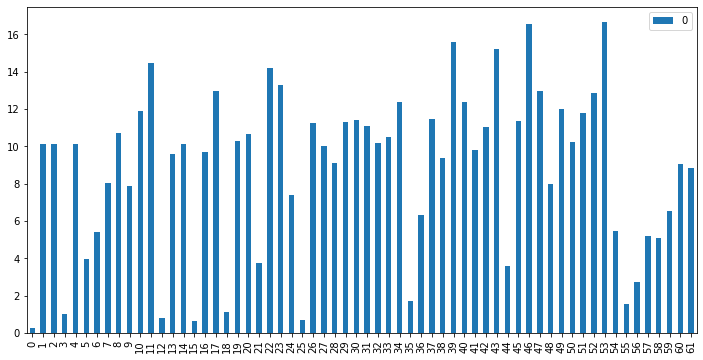

In [166]:
redirects_path, redirects_info = get_filepath(partition_dir, file_type="redirects")
pd.DataFrame(redirects_info).plot.bar(figsize=(12, 6))

In [60]:
print(f"Total size of redirect files : {np.sum(redirect_info):.2f} MB")

Total size of redirect files : 549.85 MB


In [169]:
def read_data(filename):
    
    with open(filename, 'r') as fin:
        data = json.loads(fin.read())
    return data

In [28]:
from multiprocessing.dummy import Pool as Threadpool

threadpool = Threadpool(processes= 10)

redirects_list = []
for data in tqdm.notebook.tqdm(threadpool.map(read_data, redirect_paths)):
    redirects_list.append(data)

  0%|          | 0/62 [00:00<?, ?it/s]

In [52]:
redirects = {}
for redirect in redirects_list:
    redirects.update(redirect)
    
m = re.search(r'(.*)/([0-9a-z-]+)-[0-9]+-p[0-9]+p[0-9]+_redirects.ndjson$', redirect_paths[0])
redirect_file = f'{m.group(1)}/{m.group(2)}_redirects.ndjson'

with open(redirect_file, 'wt') as fout:
    fout.write(json.dumps(redirects))

#### redirects

In [197]:
redirect_file

'/home/scai/phd/aiz218323/scratch/XML/wikipedia-data-science/partition/enwiki-20220420_redirects.ndjson'

In [170]:
redirects_file = combine_data(redirects_path)

  0%|          | 0/62 [00:00<?, ?it/s]

Save data into /home/cse/phd/anz198717/scratch/suchith_data/wikipedia/wikipedia-data-science/partition_2/enwiki-20220420_redirects.ndjson


### id_to_titles

In [158]:
import json
import tqdm
from multiprocessing.dummy import Pool as Threadpool
from multiprocessing import Pool

In [159]:
def show_fileinfo(partition_dir, file_type="redirects", save_file=None):
    
    paths, info = get_filepath(partition_dir, file_type=file_type)
    pd.DataFrame(info).plot.bar(figsize=(12, 6), ylabel='Size (MB)', xlabel='Partition ID', 
                                title=f"Total size of {file_type} files : {np.sum(info):.2f} MB")
    if save_file:
        plt.savefig(save_file)
    
    print(f"Total size of {file_type} files : {np.sum(info):.2f} MB")
    return paths, info

In [160]:
def read_data(filename):
    with open(filename, 'r') as fin:
        data = json.loads(fin.read())
    return data

In [161]:
def combine_data(paths):
    threadpool = Threadpool(processes= 10)

    data_list = []
    for data in tqdm.notebook.tqdm(threadpool.map(read_data, paths), total=len(paths)):
        data_list.append(data)
        
    combined_data = {}
    for data in data_list:
        combined_data.update(data)

    m = re.search(r'(.*)/([0-9a-z-]+)-[0-9]+-p[0-9]+p[0-9]+_([a-z-]+).ndjson$', paths[0])
    save_file = f'{m.group(1)}/{m.group(2)}_{m.group(3)}.ndjson'
    
    with open(save_file, 'wt') as fout:
        fout.write(json.dumps(combined_data))
    
    print(f"Save data into {save_file}")
    return save_file

Total size of id-to-title files : 233.62 MB


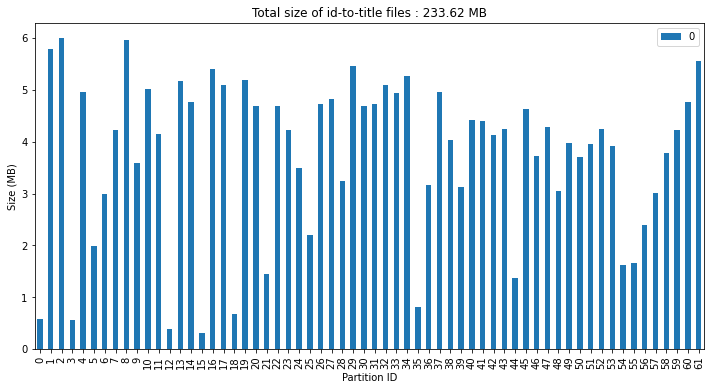

In [162]:
id_title_paths, id_title_info = show_fileinfo(partition_dir, file_type="id-to-title")

In [165]:
id_title_file = combine_data(id_title_paths)

  0%|          | 0/62 [00:00<?, ?it/s]

Save data into /home/cse/phd/anz198717/scratch/suchith_data/wikipedia/wikipedia-data-science/partition_2/enwiki-20220420_id-to-title.ndjson


In [181]:
id_title_file = f'{partition_dir}/enwiki-20220420_id-to-title.ndjson'

id_to_title = read_data(id_title_file)

In [63]:
def save_data(save_file, data):
    with open(save_file, 'wt') as fout:
        fout.write(json.dumps(data))

In [66]:
save_data(id_title_file, id_to_title)

### seealso

Total size of seealso files : 113.06 MB


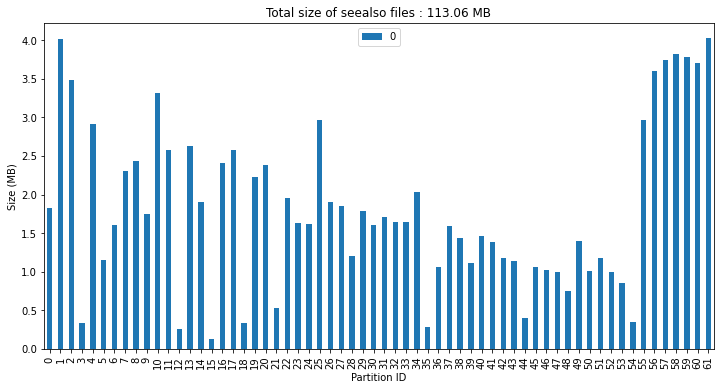

In [171]:
seealso_paths, seealso_info = show_fileinfo(partition_dir, file_type="seealso")

In [172]:
seealso_file = combine_data(seealso_paths)

  0%|          | 0/62 [00:00<?, ?it/s]

Save data into /home/cse/phd/anz198717/scratch/suchith_data/wikipedia/wikipedia-data-science/partition_2/enwiki-20220420_seealso.ndjson


In [173]:
seealso_file = f'{partition_dir}/enwiki-20220420_seealso.ndjson'

seealso = read_data(seealso_file)

### Removing redirect nodes

In [10]:
from functools import partial
from multiprocessing import Pool
from timeit import default_timer as timer

In [11]:
def replace_redirects(path, redirects):

    graph = read_data(path)
    
    for edges, _ in graph.values():
        for i, edge in enumerate(edges):
            if edge in redirects:
                edges[i] = redirects[edge]
           
    m = re.search(r'(.*)/(.*_graph).ndjson$', path)
    save_file = f"{m.group(1)}/{m.group(2)}_resolved.ndjson"
    
    with open(save_file, 'wt') as fout:
        fout.write(json.dumps(graph))
        
    return None

Total size of redirect files : 4484.27 MB


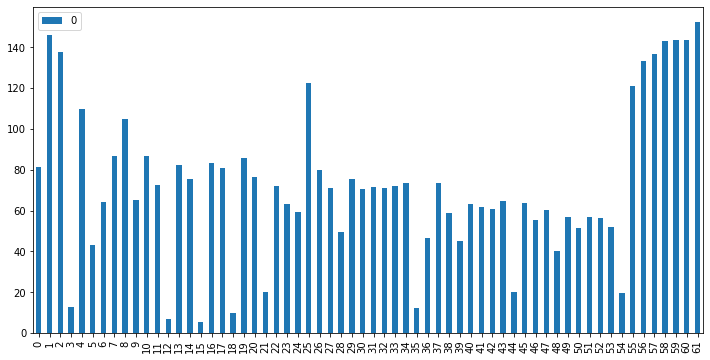

In [12]:
graph_paths, graph_info = show_fileinfo(partition_dir, file_type="graph")

In [13]:
redirect_file = '/home/scai/phd/aiz218323/scratch/XML/wikipedia-data-science/partition/enwiki-20220420_redirects.ndjson'
redirects = read_data(redirect_file)

In [18]:
start = timer()

pool = Pool(processes=24)
resolve_graph = partial(replace_redirects, redirects=redirects)

result = []
for x in tqdm.notebook.tqdm(pool.imap_unordered(resolve_graph, graph_paths), total=len(graph_paths)):
    result.append(x)

end = timer()
print(f"Processing time {end-start:.3f} seconds.")

  0%|          | 0/62 [00:10<?, ?it/s]

Processing time 602.116 seconds.


Total size of redirect files : 4514.98 MB


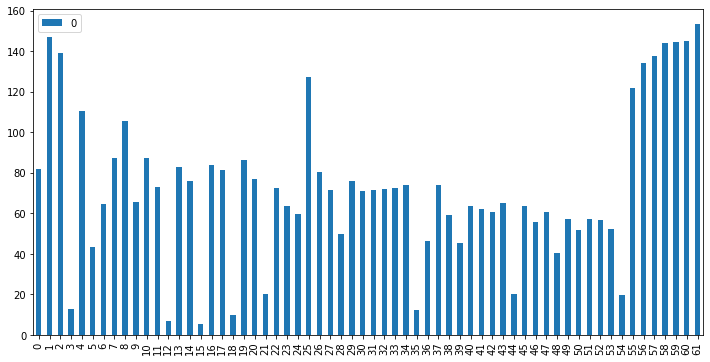

In [19]:
graph_paths, graph_info = show_fileinfo(partition_dir, file_type="graph_resolved")

## Extracting abstract

In [7]:
import gzip
import subprocess
from timeit import default_timer as timer

### Benchmarking `BeautifulSoup` and `SAX XML`

In [67]:
abstract_file = f'{abstract_dir}/{abstract_path[9]}'

#### Command line gzip vs python function

In [81]:
%%timeit -n 3 -r 3
lines = []

with gzip.open(abstract_file) as fin:
    for i, line in enumerate(fin.readlines()):
        lines.append(line)
        if i > 1e6:
            break

2.3 s ± 1.85 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [82]:
%%timeit -n 3 -r 3
lines = []

for i, line in enumerate( subprocess.Popen(['gzip','-cd'],
                                          stdin=open(abstract_file),
                                          stdout=subprocess.PIPE ).stdout ):
    lines.append(line)
    if i > 1e6:
        break

1.04 s ± 6.08 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


#### Time taken to read entire file

In [96]:
%%timeit -n 3 -r 3
with gzip.open(abstract_file) as fin:
    content = fin.read()

790 ms ± 3.54 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [97]:
content[:100]

b'<feed>\n<doc>\n<title>Wikipedia: Calm Yourself</title>\n<url>https://en.wikipedia.org/wiki/Calm_Yoursel'

In [98]:
%%timeit -n 3 -r 3
content = subprocess.Popen(['gzip','-cd'],stdin=open(abstract_file), stdout=subprocess.PIPE).stdout.read()

1.58 s ± 5.05 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [99]:
content[:100]

b'<feed>\n<doc>\n<title>Wikipedia: Calm Yourself</title>\n<url>https://en.wikipedia.org/wiki/Calm_Yoursel'

#### SAX XML

In [100]:
for i, line in enumerate( subprocess.Popen(['gzip','-cd'],
                                          stdin=open(abstract_file),
                                          stdout=subprocess.PIPE ).stdout ):
    lines.append(line)
    if i > 1e6:
        break

In [103]:
for i, line in enumerate(lines[:100]):
    print(i, line)

0 b'<feed>\n'
1 b'<doc>\n'
2 b'<title>Wikipedia: Calm Yourself</title>\n'
3 b'<url>https://en.wikipedia.org/wiki/Calm_Yourself</url>\n'
4 b'<abstract>| starring       = Robert YoungMadge EvansBetty FurnessRalph MorganNat PendletonHardie Albright</abstract>\n'
5 b'<links>\n'
6 b'<sublink linktype="nav"><anchor>Plot</anchor><link>https://en.wikipedia.org/wiki/Calm_Yourself#Plot</link></sublink>\n'
7 b'<sublink linktype="nav"><anchor>Cast</anchor><link>https://en.wikipedia.org/wiki/Calm_Yourself#Cast</link></sublink>\n'
8 b'<sublink linktype="nav"><anchor>References</anchor><link>https://en.wikipedia.org/wiki/Calm_Yourself#References</link></sublink>\n'
9 b'<sublink linktype="nav"><anchor>External links</anchor><link>https://en.wikipedia.org/wiki/Calm_Yourself#External_links</link></sublink>\n'
10 b'</links>\n'
11 b'</doc>\n'
12 b'<doc>\n'
13 b'<title>Wikipedia: Reg Lewis (bodybuilder)</title>\n'
14 b'<url>https://en.wikipedia.org/wiki/Reg_Lewis_(bodybuilder)</url>\n'
15 b'<abstract>Regin

In [104]:
page = lines[1:12]; page

[b'<doc>\n',
 b'<title>Wikipedia: Calm Yourself</title>\n',
 b'<url>https://en.wikipedia.org/wiki/Calm_Yourself</url>\n',
 b'<abstract>| starring       = Robert YoungMadge EvansBetty FurnessRalph MorganNat PendletonHardie Albright</abstract>\n',
 b'<links>\n',
 b'<sublink linktype="nav"><anchor>Plot</anchor><link>https://en.wikipedia.org/wiki/Calm_Yourself#Plot</link></sublink>\n',
 b'<sublink linktype="nav"><anchor>Cast</anchor><link>https://en.wikipedia.org/wiki/Calm_Yourself#Cast</link></sublink>\n',
 b'<sublink linktype="nav"><anchor>References</anchor><link>https://en.wikipedia.org/wiki/Calm_Yourself#References</link></sublink>\n',
 b'<sublink linktype="nav"><anchor>External links</anchor><link>https://en.wikipedia.org/wiki/Calm_Yourself#External_links</link></sublink>\n',
 b'</links>\n',
 b'</doc>\n']

In [115]:
class AbstractXmlHandler(xml.sax.handler.ContentHandler):
    
    def __init__(self):
        xml.sax.handler.ContentHandler.__init__(self)
        self._buffer = None
        self._values = {}
        self._current_tag = None
        
        self._pages = []
        
    def characters(self, content):
        if self._current_tag:
            self._buffer.append(content)
            
    def startElement(self, name, attrs):
        if name in ('title','abstract'):
            self._current_tag = name
            self._buffer = []
            
    def endElement(self, name):
        if name == self._current_tag:
            self._values[name] = ' '.join(self._buffer)
            self._current_tag = None
                
        elif name == 'doc':
            self._pages.append( (self._values['title'], self._values['abstract']) )

__Reading a page__

In [116]:
handler = AbstractXmlHandler()

parser = xml.sax.make_parser()
parser.setContentHandler(handler)

handler._pages

[]

In [117]:
for line in page:
    parser.feed(line)

In [118]:
handler._pages

[('Wikipedia: Calm Yourself',
  '| starring       = Robert YoungMadge EvansBetty FurnessRalph MorganNat PendletonHardie Albright')]

__Reading entire file__

In [124]:
start = timer()

handler = AbstractXmlHandler()

parser = xml.sax.make_parser()
parser.setContentHandler(handler)

for i, line in enumerate( subprocess.Popen(['gzip','-cd'],
                                          stdin=open(abstract_file),
                                          stdout=subprocess.PIPE ).stdout ):
    try:
        parser.feed(line)
    except StopIteration:
        break
        
    """
    if len(handler._pages) > 3:
        break
    """ 

end = timer()
print(f"Time taken : {end - start} seconds")

Time taken : 9.331946671009064 seconds


In [126]:
len(handler._pages)

174715

#### BeautifulSoup

In [128]:
start = timer()

with gzip.open(abstract_file) as fin:
    content = fin.read()

soup_abstract = BeautifulSoup(content, 'xml')

end = timer()
print(f"Time taken : {end - start} seconds")

Time taken : 179.1401414759457 seconds


BeautifulSoup is taking way more time.

### Parsing Abstract with XML

In [146]:
class AbstractXmlHandler(xml.sax.handler.ContentHandler):
    
    def __init__(self):
        xml.sax.handler.ContentHandler.__init__(self)
        self._buffer = None
        self._values = {}
        self._current_tag = None
        self._article_count = 0
        
        self._abstract = {}
        
    def characters(self, content):
        if self._current_tag:
            self._buffer.append(content)
            
    def startElement(self, name, attrs):
        if name in ('title','abstract'):
            self._current_tag = name
            self._buffer = []
            
    def endElement(self, name):
        if name == self._current_tag:
            self._values[name] = ' '.join(self._buffer)
            self._current_tag = None
                
        elif name == 'doc':
            self._article_count += 1
            cat, title = self._values['title'].split(':', maxsplit=1)
            self._abstract[title.strip()] = self._values['abstract'].strip()

In [147]:
abstract_file = f'{abstract_dir}/{abstract_path[9]}'

In [148]:
start = timer()

handler = AbstractXmlHandler()

parser = xml.sax.make_parser()
parser.setContentHandler(handler)

for i, line in enumerate( subprocess.Popen(['gzip','-cd'],
                                          stdin=open(abstract_file),
                                          stdout=subprocess.PIPE ).stdout ):
    try:
        parser.feed(line)
    except StopIteration:
        break
        
    """
    if len(handler._pages) > 3:
        break
    """ 

end = timer()
print(f"Time taken : {end - start} seconds")

Time taken : 10.484727837145329 seconds


In [149]:
handler._abstract

{'Calm Yourself': '| starring       = Robert YoungMadge EvansBetty FurnessRalph MorganNat PendletonHardie Albright',
 'Reg Lewis (bodybuilder)': 'Reginald Bernie Lewis (January 23, 1936 – February 11, 2021) was an American bodybuilder and actor.',
 'Otakar Hromádko': '|birth_place = Kněž, Bohemia, Austria-Hungary(now Czech Republic)',
 'La odalisca No. 13': '| runtime        = 90 minutes',
 'List of Mind Trekkers events': 'This is a list of Mind Trekkers events.',
 '2014 Zuiderduin Masters': 'Geert De Vos',
 'Marta Ruedas': 'Marta Ruedas is a United Nations civil servant who has worked in many countries around the world, initially with the United Nations Development Programme, including Bolivia, Kyrgyzstan, the Republic of Georgia, Nepal, Mongolia and Mexico, as well as at its headquarters in New York.  The organization assists countries in reaching their targets in economic and social development.',
 'Pietro Ceccaroni': '| birth_place         = Sarzana, Italy',
 'Garry Lewis (gridiron

#### Multiprocessing

In [150]:
def extract_abstract(abstract_file):
    
    handler = AbstractXmlHandler()

    parser = xml.sax.make_parser()
    parser.setContentHandler(handler)

    for i, line in enumerate( subprocess.Popen(['gzip','-cd'],
                                              stdin=open(abstract_file),
                                              stdout=subprocess.PIPE ).stdout ):
        try:
            parser.feed(line)
        except StopIteration:
            break
            
    return handler._abstract

In [152]:
from multiprocessing import Pool
import json
import tqdm

In [165]:
pool = Pool(processes=15)

abstracts = {}

for abstract in tqdm.notebook.tqdm(pool.imap_unordered(extract_abstract, abstract_paths), total=len(abstract_paths)):
    abstracts.update(abstract)

  0%|          | 0/27 [00:00<?, ?it/s]

In [168]:
abstract_paths[0]

'/home/scai/phd/aiz218323/scratch/XML/wikipedia-data-science/datasets/enwiki-20220420-abstract1.xml.gz'

In [175]:
partition_dir = f'{dataset_home}/partition_2'
save_abstract = f'{partition_dir}/enwiki-20220420-abstracts.ndjson'

In [169]:
with open(save_abstract, 'wt') as file:
    file.write(json.dumps(abstracts))

In [176]:
save_abstract

'/home/cse/phd/anz198717/scratch/suchith_data/wikipedia/wikipedia-data-science/partition_2/enwiki-20220420-abstracts.ndjson'

In [177]:
abstracts = read_data(save_abstract)

In [178]:
abstracts

{'Calm Yourself': '| starring       = Robert YoungMadge EvansBetty FurnessRalph MorganNat PendletonHardie Albright',
 'Reg Lewis (bodybuilder)': 'Reginald Bernie Lewis (January 23, 1936 – February 11, 2021) was an American bodybuilder and actor.',
 'Otakar Hromádko': '|birth_place = Kněž, Bohemia, Austria-Hungary(now Czech Republic)',
 'La odalisca No. 13': '| runtime        = 90 minutes',
 'List of Mind Trekkers events': 'This is a list of Mind Trekkers events.',
 '2014 Zuiderduin Masters': 'Geert De Vos',
 'Marta Ruedas': 'Marta Ruedas is a United Nations civil servant who has worked in many countries around the world, initially with the United Nations Development Programme, including Bolivia, Kyrgyzstan, the Republic of Georgia, Nepal, Mongolia and Mexico, as well as at its headquarters in New York.  The organization assists countries in reaching their targets in economic and social development.',
 'Pietro Ceccaroni': '| birth_place         = Sarzana, Italy',
 'Garry Lewis (gridiron

In [182]:
len(id_to_title), len(abstracts)

(6473083, 6487916)

#### Modifying `id_to_title`

In [186]:
def modify_title_punctuation(title):
    title_split = title.split('"')
    for i in range(len(title_split)):
        if i == 0:
            title_split[i] = title_split[i][:-1]
        elif i == len(title_split)-1:
            title_split[i] = title_split[i][1:]
        else:
            title_split[i] = title_split[i][1:-1]
    return '"'.join(title_split)

In [187]:
for page_id, title in id_to_title.items():
    if '"' in title:
        modified_title = modify_title_punctuation(title)
        id_to_title[page_id] = modified_title

In [188]:
abstract_absent = []

for title in id_to_title.values():
    if title not in abstracts:
        abstract_absent.append(title)

In [189]:
abstract_absent

['Church of St Michael the Archangel, Framlingham',
 'San Telmo (ship)',
 'Knjaz Miloš a.d.',
 'Drift station',
 'Traffic school',
 'J. Dringwell Rymbai',
 'ESDA',
 'M-Pio Co.',
 'Blonay–Chamby museum railway',
 'Arrows of English Warbows',
 'Vextra 105mm',
 'Mithi Tehsil',
 'Frederick Institute of Technology',
 'Free Norwegian forces',
 'Margarita Cedeño de Fernández',
 'Turner Broadcasting System Europe',
 'List of mayors of Princeton, Indiana',
 'Houston Christian High School',
 'Global Domination (video game)',
 "89th Division (2nd Formation)(People's Republic of China)",
 'Filtered Air Positive Pressure',
 'David Griffiths (rugby league)',
 "Marlbrough s'en va-t-en guerre",
 'List of trails in Colorado',
 'Linton, Penyard',
 "Nick 'n Neal live in Europe – Two Separate Gorillas",
 'Shevchenkove, Shevchenkove settlement hromada, Kupiansk Raion, Kharkiv Oblast',
 'Web-based taxonomy',
 'The Exterminating Angels (film)',
 'Kamiakin Junior High School',
 'WOHL',
 'Pre-Modern Aliyah',
 

In [185]:
with open(f"{partition_dir}/abstract_titles.txt", 'w') as file:
    file.writelines( '\n'.join( list(abstracts.keys()) ) )

In [190]:
def save_data(save_file, data):
    with open(save_file, 'wt') as fout:
        fout.write(json.dumps(data))

In [192]:
save_data(id_title_file, id_to_title)

## Graph Statistics

Total size of graph_resolved files : 4514.98 MB


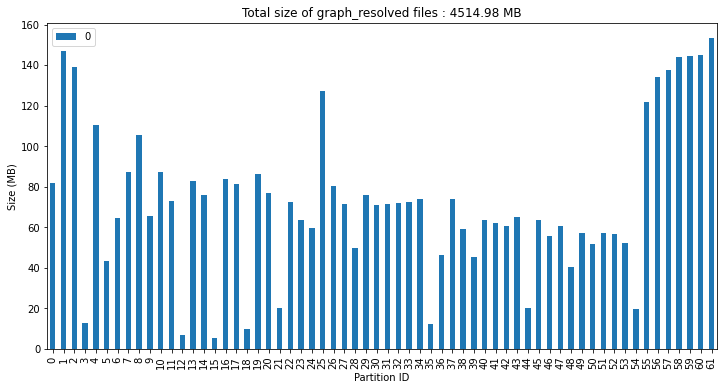

In [13]:
infosave_file = f'{dataset_home}/data/graph_resolved.jpg'
graph_paths, graph_info = show_fileinfo(partition_dir, file_type="graph_resolved", save_file=infosave_file)

In [28]:
def count_graph_stats(filename):
    graph = read_data(filename)
    
    edge_count = 0
    for edges, counts in graph.values():
        edge_count += len(counts)
    
    nodes = list(graph)
        
    return (edge_count, len(graph)), nodes

In [29]:
pool = Pool(processes=10)

nodes = []
results = []

for x, n in tqdm.notebook.tqdm( pool.imap(count_graph_stats, graph_paths), total=len(graph_paths)):
    results.append(x)
    nodes.extend(n)

  0%|          | 0/62 [00:00<?, ?it/s]

In [30]:
pd.DataFrame(np.sum(results, axis=0)[None], columns=["Number of edges", "Number of nodes"])

,Number of edges,Number of nodes
0,175085364,6470952


Let's see if we get same statistics with `id_to_title`.

In [18]:
id_title_file = f'{partition_dir}/enwiki-20220420_id-to-title.ndjson'
id_to_title = read_data(id_title_file)

In [40]:
nodes_map = list(id_to_title)
len(id_to_title)

6472830

Nooo, there is discrepency here, lets see if we can explain this.

In [43]:
len(nodes), nodes[:10]

(6470952, ['12', '25', '39', '290', '303', '305', '307', '308', '309', '316'])

In [44]:
len(nodes_map), nodes_map[:10]

(6472830, ['12', '25', '39', '290', '303', '305', '307', '308', '309', '316'])

In [46]:
n1 = set(nodes)
n2 = set(nodes_map)

In [58]:
diff_n = list(n2.difference(n1)); len(diff_n)

1878

In [59]:
diff_n[:10]

['35722424',
 '64090623',
 '33258851',
 '41909935',
 '42974571',
 '27030148',
 '33258872',
 '33136869',
 '68618618',
 '62217528']

These might be files without links in the all other sections but `see also`.

### Reading seealso links

Total size of seealso files : 113.17 MB


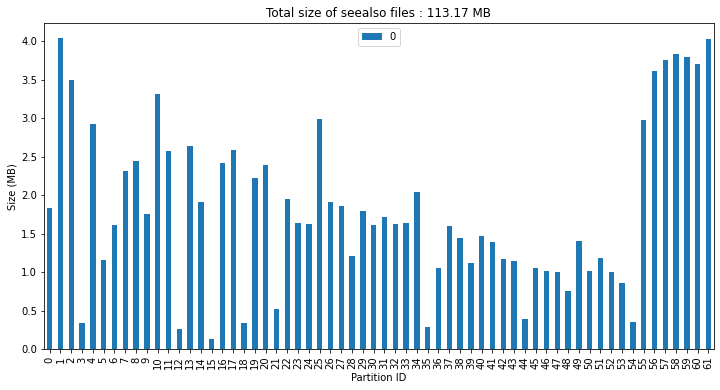

In [52]:
infosave_file = f'{dataset_home}/data/seealso.jpg'
seealso_paths, seealso_info = show_fileinfo(partition_dir, file_type="seealso", save_file=infosave_file)

In [56]:
seealso_file = f'{partition_dir}/enwiki-20220420_seealso.ndjson'

seealso = read_data(seealso_file)

In [64]:
diff_n_not_present_seealso = list()

for n in diff_n:
    if n not in seealso:
        diff_n_not_present_seealso.append(n)
        
len(diff_n_not_present_seealso)

0

Thus verified.

## Notes Stuff

Total size of graph files : 4484.27 MB
Total size of seealso files : 113.17 MB
Total size of redirects files : 549.85 MB
Total size of id-to-title files : 233.61 MB
Total size of page-content files : 28257.41 MB


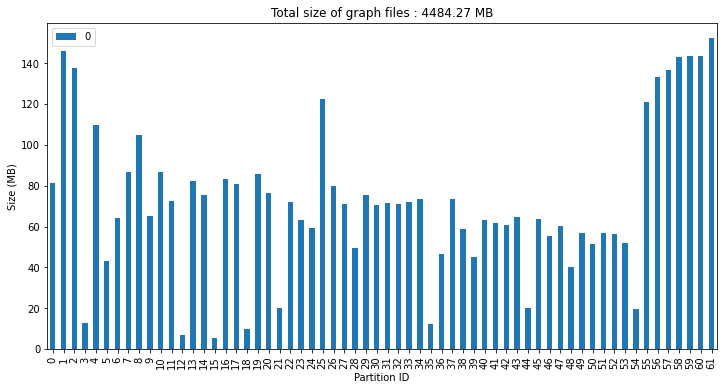

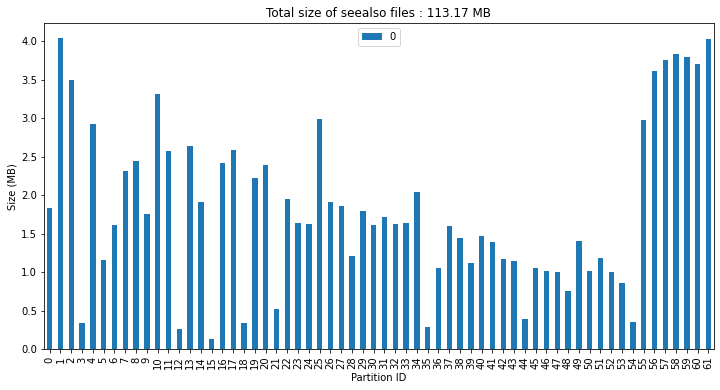

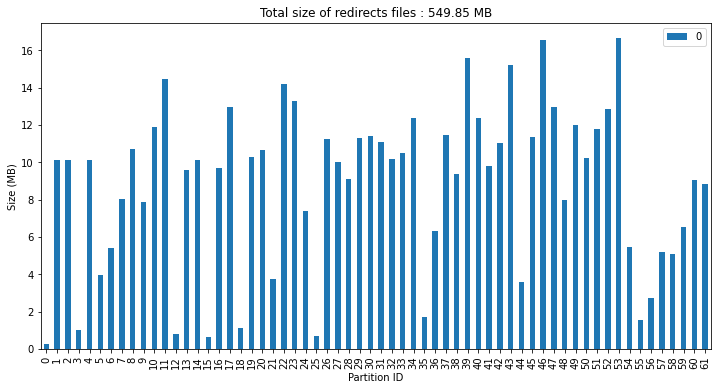

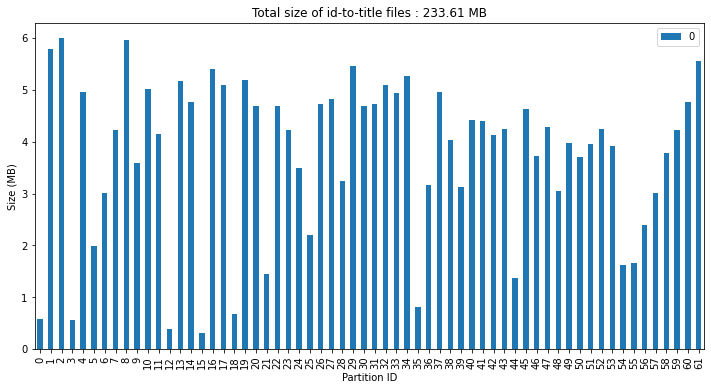

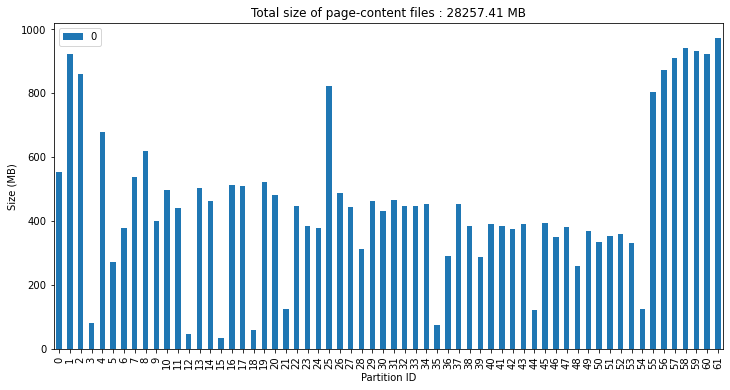

In [66]:
file_types = ['graph', 'seealso', 'redirects', 'id-to-title', 'page-content']
comb_paths = []

for file_type in file_types:
    infosave_file = f'{dataset_home}/data/{file_type}.jpg'
    paths, info = show_fileinfo(partition_dir, file_type=file_type, save_file=infosave_file)
    comb_paths.append(paths)

In [74]:
comb_paths[-1]

['/home/scai/phd/aiz218323/scratch/XML/wikipedia-data-science/partition/enwiki-20220420-1-p1p41242_page-content.ndjson',
 '/home/scai/phd/aiz218323/scratch/XML/wikipedia-data-science/partition/enwiki-20220420-10-p4045403p5399366_page-content.ndjson',
 '/home/scai/phd/aiz218323/scratch/XML/wikipedia-data-science/partition/enwiki-20220420-11-p5399367p6899366_page-content.ndjson',
 '/home/scai/phd/aiz218323/scratch/XML/wikipedia-data-science/partition/enwiki-20220420-11-p6899367p7054859_page-content.ndjson',
 '/home/scai/phd/aiz218323/scratch/XML/wikipedia-data-science/partition/enwiki-20220420-12-p7054860p8554859_page-content.ndjson',
 '/home/scai/phd/aiz218323/scratch/XML/wikipedia-data-science/partition/enwiki-20220420-12-p8554860p9172788_page-content.ndjson',
 '/home/scai/phd/aiz218323/scratch/XML/wikipedia-data-science/partition/enwiki-20220420-13-p10672789p11659682_page-content.ndjson',
 '/home/scai/phd/aiz218323/scratch/XML/wikipedia-data-science/partition/enwiki-20220420-13-p91727

In [72]:
id_to_title

{'12': 'Anarchism',
 '25': 'Autism',
 '39': 'Albedo',
 '290': 'A',
 '303': 'Alabama',
 '305': 'Achilles',
 '307': 'Abraham Lincoln',
 '308': 'Aristotle',
 '309': 'An American in Paris',
 '316': 'Academy Award for Best Production Design',
 '324': 'Academy Awards',
 '330': 'Actrius',
 '332': 'Animalia (book)',
 '334': 'International Atomic Time',
 '336': 'Altruism',
 '339': 'Ayn Rand',
 '340': 'Alain Connes',
 '344': 'Allan Dwan',
 '358': 'Algeria',
 '359': 'List of Atlas Shrugged characters',
 '569': 'Anthropology',
 '572': 'Agricultural science',
 '573': 'Alchemy',
 '579': 'Alien',
 '580': 'Astronomer',
 '586': 'ASCII',
 '590': 'Austin (disambiguation)',
 '593': 'Animation',
 '594': 'Apollo',
 '595': 'Andre Agassi',
 '597': 'Austroasiatic languages',
 '599': 'Afroasiatic languages',
 '600': 'Andorra',
 '612': 'Arithmetic mean',
 '615': 'American Football Conference',
 '620': 'Animal Farm',
 '621': 'Amphibian',
 '624': 'Alaska',
 '627': 'Agriculture',
 '628': 'Aldous Huxley',
 '630': 'A